In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

9925
(1024, 1024, 1) [13]
dict_keys(['image', 'label', 'path'])
torch.Size([1, 768, 768]) [13]


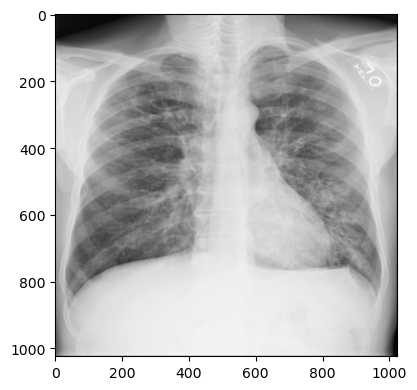

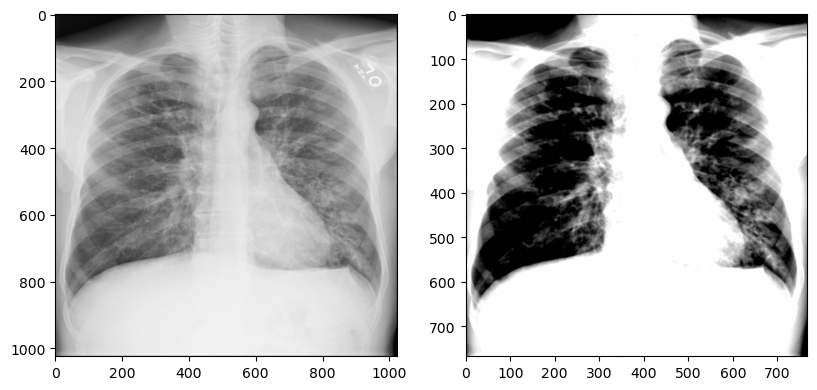

(1024, 1024, 1) [13]
(512, 512, 1) [13]
(1, 512, 512) [13]
torch.Size([1, 512, 512]) [13] torch.float32
{'Atelectasis': 0.010142122,
 'Cardiomegaly': 0.005525759,
 'Consolidation': 0.016978966,
 'Edema': 0.012241232,
 'Effusion': 0.04025645,
 'Emphysema': 0.002883517,
 'Enlarged Cardiomediastinum': 0.5,
 'Fibrosis': 0.035398975,
 'Fracture': 0.004296485,
 'Hernia': 0.00013901615,
 'Infiltration': 0.2623291,
 'Lung Lesion': 0.5,
 'Lung Opacity': 0.7161336,
 'Mass': 0.004851207,
 'Nodule': 0.122413814,
 'Pleural_Thickening': 0.007470357,
 'Pneumonia': 0.07959056,
 'Pneumothorax': 0.007914973}


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
import torchxrayvision as xrv
import albumentations as A
from functools import partial
from univdt.components import NIH
from univdt.transforms.builder import AVAILABLE_TRANSFORMS

root_dir = 'C:\\nih\\nih' # TODO: set root dir
nih = partial(NIH, root_dir=root_dir, transform=None)

# nih_train = nih(split='train')
# print(len(nih_train))
# assert len(nih_train) == 76599

nih_val = nih(split='val')
print(len(nih_val))
assert len(nih_val) == 9925

# nih_test = nih(split='test')
# print(len(nih_test))
# assert len(nih_test) == 25596

# nih_trainval = nih(split='trainval')
# print(len(nih_trainval))
# assert len(nih_trainval) == 76599+9925

data= nih_val.load_data(0)
image = data['image']
label = data['label']
print(image.shape, label) 
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')

DEFAULT_HEIGHT = 768
DEFAULT_WIDTH = 768
DEFAULT_TRAIN_TRANSFORMS = A.Compose([AVAILABLE_TRANSFORMS['random_resize'](height=DEFAULT_HEIGHT,
                                                                            width=DEFAULT_WIDTH,
                                                                            pad_val=0, p=1.0),
                                      A.HorizontalFlip(p=0.5),
                                      AVAILABLE_TRANSFORMS['random_blur'](magnitude=0.2, p=0.5),
                                      AVAILABLE_TRANSFORMS['random_brightness'](magnitude=0.2, p=0.5),
                                      AVAILABLE_TRANSFORMS['random_contrast'](magnitude=0.2, p=0.5),
                                      AVAILABLE_TRANSFORMS['random_gamma'](magnitude=0.2, p=0.5),
                                      AVAILABLE_TRANSFORMS['random_noise'](magnitude=0.2, p=0.5),
                                      AVAILABLE_TRANSFORMS['random_windowing'](magnitude=0.5, p=0.5),
                                      AVAILABLE_TRANSFORMS['random_zoom'](scale=0.2, pad_val=0, p=0.5),
                                      A.Affine(rotate=(-45, 45), p=0.5),
                                      A.Affine(translate_percent=(0.01, 0.1), p=0.5),
                                      ])

nih_val = NIH(root_dir=root_dir, transform=DEFAULT_TRAIN_TRANSFORMS, split='val')

data = nih_val.load_data(0)

# __getitem__ 메서드를 호출

batch = nih_val[0]

print(batch.keys())
print(batch['image'].shape, batch['label'])

plt.figure(figsize=(15,5))
original_image = cv2.imread(batch['path'])
plt.subplot(1,3,1)
plt.imshow(original_image)

transformed = batch['image']
plt.subplot(1,3,2)
transformed = transformed.numpy().transpose(1,2,0)
plt.imshow(transformed, cmap='gray')
plt.show()

data= nih_val.load_data(0)
image = data['image']
label = data['label']
print(image.shape, label) 

image = cv2.resize(image, (512,512))
image = np.expand_dims(image, axis=2)
print(image.shape, label)

image = xrv.datasets.normalize(image, 255) 
image:np.ndarray = image.mean(2)[None, ...] # Make single color channel
image = image.astype(dtype=np.float32)
print(image.shape, label)
image = torch.from_numpy(image)
print(image.shape, label, image.dtype)

model = xrv.models.ResNet(weights="resnet50-res512-all")
outputs = model(image[None,...]) # or model.features(img[None,...]) 

from pprint import pprint 
pprint(dict(zip(model.pathologies,outputs[0].detach().numpy())))
